In [ ]:
import numpy as np
import cv2
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from diffusers import StableDiffusionInpaintPipeline
import torch

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16,
)
pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

StableDiffusionInpaintPipeline {
  "_class_name": "StableDiffusionInpaintPipeline",
  "_diffusers_version": "0.33.1",
  "_name_or_path": "stabilityai/stable-diffusion-2-inpainting",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": false,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [ ]:
# !pip install ultralytics

In [ ]:
from ultralytics import YOLO

# Load YOLO model
model = YOLO("/content/drive/My Drive/yolo11l-seg-cad.pt")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
results = model.predict(source="/content/*.png", save=True, save_txt=True)


image 1/1 /content/0000-0002.png: 640x640 7 single doors, 3 windows, 4 beds, 4 chairs, 1 table, 6 tv cabinets, 2 wardrobes, 2 cabinets, 2 sinks, 2 baths, 3 toilets, 61.1ms
Speed: 16.6ms preprocess, 61.1ms inference, 505.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/segment/predict
1 label saved to runs/segment/predict/labels


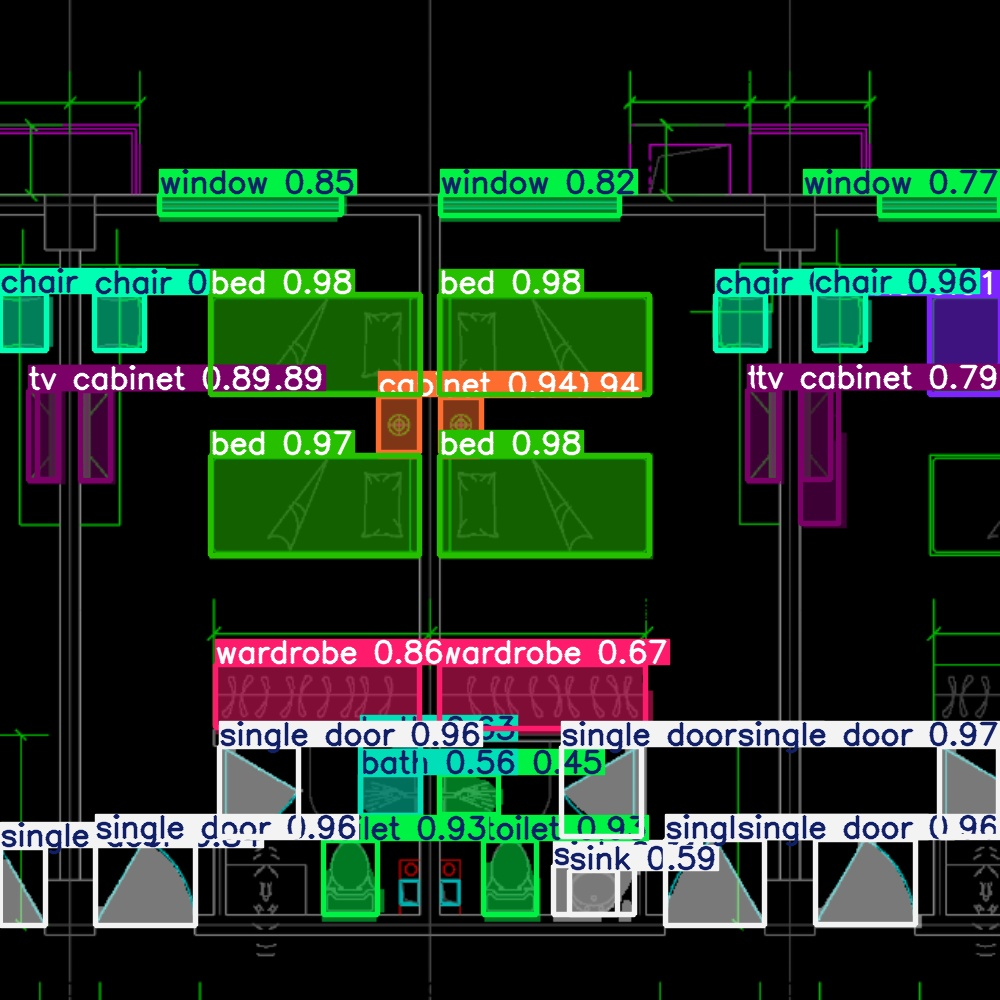

In [ ]:
from IPython.display import Image as IPyImage
from glob import glob

# Show the result image
result_path = glob("runs/segment/predict/*.jpg")[0]  # or .png
IPyImage(filename=result_path)

In [27]:
import re

r = results[0]
masks = r.masks.data.cpu().numpy()
classes = r.boxes.cls.cpu().numpy().astype(int)
confidences = r.boxes.conf.cpu().numpy()
class_names = r.names
image_np = r.orig_img

prompt = "remove the bed and fill with floor texture"
confidence_threshold = 0.85

# Extract class from prompt
target_class_name = None
for name in class_names.values():
    if re.search(rf"\b{name}\b", prompt.lower()):
        target_class_name = name
        break

if target_class_name is None:
    raise ValueError("Could not match any class in prompt.")

print(f"Matched class: {target_class_name}")

Matched class: bed


In [ ]:
# Create combined mask for target class
target_class_id = [i for i, name in class_names.items() if name == target_class_name][0]
edit_mask = np.zeros_like(masks[0], dtype=np.uint8)

for i, cls in enumerate(classes):
    if cls == target_class_id and confidences[i] >= confidence_threshold:
        mask_i = masks[i]
        if mask_i.ndim == 3:
            mask_i = mask_i[0]
        edit_mask = np.maximum(edit_mask, mask_i)

# process mask
edit_mask = (edit_mask > 0).astype(np.uint8) * 255
edit_mask = cv2.dilate(edit_mask, np.ones((5, 5), np.uint8))

cv2.imwrite("mask.png", edit_mask)
Image.fromarray(image_np).save("image.png")

image = Image.open("image.png").convert("RGB").resize((512, 512))
mask = Image.open("mask.png").convert("L").resize((512, 512))

print("Image mode:", image.mode, "Size:", image.size)
print("Mask mode:", mask.mode, "Size:", mask.size)


# in_painting
output = pipe(
    prompt=prompt,
    image=image,
    mask_image=mask,
    strength=0.9,
    guidance_scale=7.5,
    num_inference_steps=120,
).images[0]

output.save("inpainted.png")
output.show()

Image mode: RGB Size: (512, 512)
Mask mode: L Size: (512, 512)


  0%|          | 0/108 [00:00<?, ?it/s]

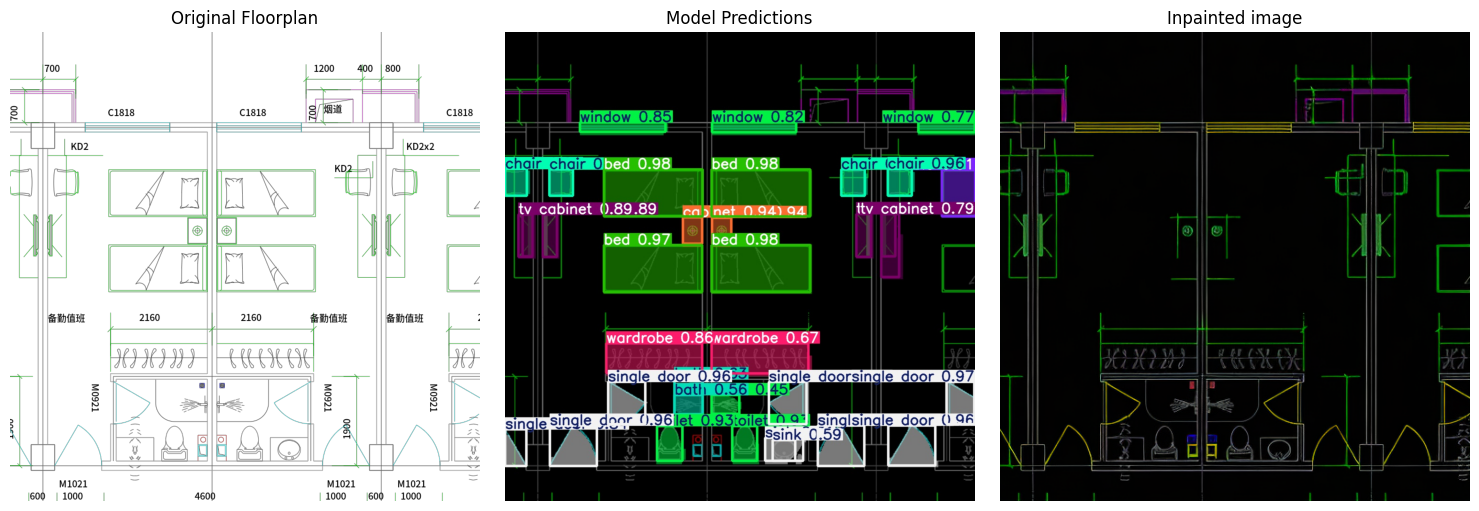

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

original = Image.open("/content/0000-0002.png")
pred = Image.open(result_path)
edited = Image.open("inpainted.png")

# Plot all three
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(original)
plt.title("Original Floorplan")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(pred, cmap='gray')
plt.title("Model Predictions")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(edited, cmap='gray')
plt.title("Inpainted image")
plt.axis("off")

plt.tight_layout()
plt.show()
